# Exploring your Home Assistant data

The goal of this page is to get you familiar with the data in your Home Assistant instance. The page you're reading right now is a Jupyter Notebook. These documents contain instructions for the user and embedded Python code to generate graphs and tables of your data. It's interactive so you can at any time change the code of any example and just press the ▶️ button to update the example with your changes! 

To get started, let's execute all examples on this page: in the menu at the top left, click on "Run" -> "Run All Cells".

In [1]:
from detective.core import db_from_hass_config
db = db_from_hass_config()

Successfully connected to database
There are 75 entities with data


## Popular entities

In the following example, we're going to explore your most popular entities and break it down per period of the day (morning/afternoon/evening/night).

We will do this by looking at which services are getting called and which entities they targeted. To make the results more relevant, we will filter out any service call that happened because of another service call. So if a user turns on a script which turns on a light, we only count the interaction with the script and not with the light.

In [2]:
%%time
from collections import Counter, OrderedDict
import json

from detective.time import time_category, sqlalch_datetime, localize, TIME_CATEGORIES

# Prepare a dictionary to track results
results = OrderedDict((time_cat, Counter()) for time_cat in TIME_CATEGORIES)

# We keep track of contexts that we processed so that we will only process
# the first service call in a context, and not subsequent calls.
context_processed = set()

for event in db.perform_query("SELECT * FROM events WHERE event_type = 'call_service' ORDER BY time_fired"):
    entity_ids = None

    # Skip if we have already processed an event that was part of this context
    if event.context_id in context_processed:
        continue

    try:
        event_data = json.loads(event.event_data)
    except ValueError:
        continue

    # Empty event data, skipping (shouldn't happen, but to be safe)
    if not event_data:
        continue

    service_data = event_data.get('service_data')

    # No service data found, skipping
    if not service_data:
        continue

    entity_ids = service_data.get('entity_id')

    # No entitiy IDs found, skip this event
    if entity_ids is None:
        continue

    if not isinstance(entity_ids, list):
        entity_ids = [entity_ids]

    context_processed.add(event.context_id)

    period = time_category(
        localize(sqlalch_datetime(event.time_fired)))

    for entity_id in entity_ids:
        results[period][entity_id] += 1

# TODO: convert to nice Pandas DataFrame
print("Most popular entities to interact with:")

for period, period_results in results.items():
    entities = [ent_id for (ent_id, count) in period_results.most_common(5)]
    result = ', '.join(entities) if entities else '-'
    print(f"{period}: {result}")


Most popular entities to interact with:
morning: light.kitchen, image_processing.clarifai_live_view, remote.living_room_8
daytime: media_player.living_room_6, remote.living_room_5
evening: light.kitchen, image_processing.clarifai_live_view
night: light.kitchen, light.hue_white_lamp_2
CPU times: user 111 ms, sys: 38.9 ms, total: 150 ms
Wall time: 518 ms


We now use pandas to visualise the results

In [3]:
import pandas as pd

In [4]:
df = pd.DataFrame.from_dict(results)

In [5]:
df

,morning,daytime,evening,night
image_processing.clarifai_live_view,5.0,NaN,2.0,NaN
light.hue_white_lamp_2,NaN,NaN,NaN,2.0
light.kitchen,9.0,NaN,4.0,14.0
media_player.living_room_6,NaN,1.0,NaN,NaN
remote.living_room_5,NaN,1.0,NaN,NaN
remote.living_room_8,4.0,NaN,NaN,NaN


## View states
Detective makes it easy to view your state data as a pandas dataframe.

In [6]:
%%time
db.fetch_all_data()

Querying the database, this could take a while
master_df created successfully.
CPU times: user 8.51 s, sys: 1 s, total: 9.51 s
Wall time: 18 s


We now have the raw data in a Pandas dataframe on the `master_df` attribute of our `db` objecy. We must use another class to process this data into a format suitable for plotting. Detective provides helper classes for working with numerical senor data and binary sensor data. 

Lets first assert that you have data in each class:

In [7]:
assert 'binary_sensor' and 'sensor' in db.domains

If you received an `AssertionError` on the above cell, some of the following may not work for you.

Assuming no error was raised, lets splot some numerical sensor data

In [8]:
db.entities['sensor']

['sensor.serial_sensor',
 'sensor.pressure',
 'sensor.temperature',
 'sensor.particles_03um',
 'sensor.particles_05um',
 'sensor.particles_10um',
 'sensor.particles_25um',
 'sensor.mqtt_sensor',
 'sensor.particles_50um',
 'sensor.humidity',
 'sensor.yr_symbol',
 'sensor.particles_100um',
 'sensor.robins_iphone_battery_level',
 'sensor.robins_iphone_battery_state']

In [9]:
from detective.core import NumericalSensors
numerical_sensors = NumericalSensors(db.master_df)

You can quickly see what numerical entities are available:

In [10]:
numerical_sensors.entities

['sensor.yr_symbol',
 'sensor.humidity',
 'sensor.temperature',
 'sensor.pressure',
 'sensor.robins_iphone_battery_level',
 'sensor.particles_03um',
 'sensor.particles_05um',
 'sensor.particles_10um',
 'sensor.particles_25um',
 'sensor.particles_50um',
 'sensor.particles_100um']

We can access the numerical data as a pandas dataframe on the `data` attribute and print out the first couple of rows of data

In [11]:
numerical_sensors.data.head()

entity,sensor.humidity,sensor.particles_03um,sensor.particles_05um,sensor.particles_100um,sensor.particles_10um,sensor.particles_25um,sensor.particles_50um,sensor.pressure,sensor.robins_iphone_battery_level,sensor.temperature,sensor.yr_symbol
last_changed,,,,,,,,,,,
2018-11-09 07:33:10.525785,72.4,1608.0,443.0,0.0,59.0,1.0,0.0,1003.5,100.0,22.8,4.0
2018-11-09 07:33:11.402998,72.4,1617.0,443.0,0.0,59.0,1.0,0.0,1003.5,100.0,22.8,4.0
2018-11-09 07:33:11.404225,72.4,1617.0,453.0,0.0,59.0,1.0,0.0,1003.5,100.0,22.8,4.0
2018-11-09 07:33:11.406182,72.4,1617.0,453.0,0.0,62.0,1.0,0.0,1003.5,100.0,22.8,4.0
2018-11-09 07:33:12.291884,72.4,1623.0,453.0,0.0,62.0,1.0,0.0,1003.5,100.0,22.8,4.0


Lets plot a random numerical sensor

In [12]:
import random

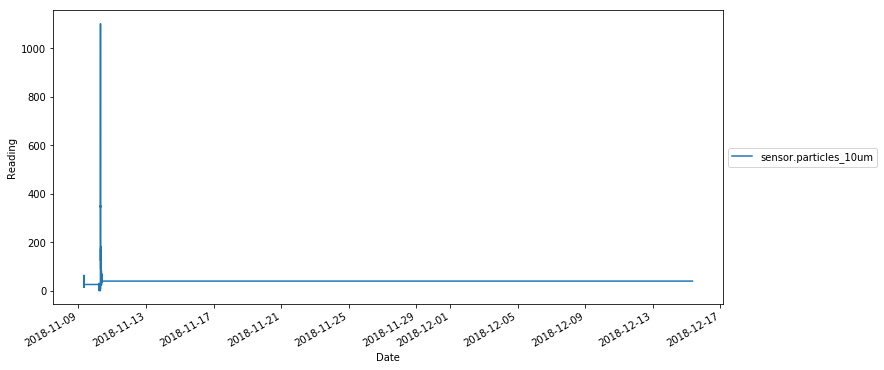

In [13]:
numerical_sensors.plot(random.choice(numerical_sensors.entities))

Lets now plot data of a binary sensor:

In [14]:
from detective.core import BinarySensors
binary_sensors = BinarySensors(db.master_df)

/usr/local/lib/python3.6/dist-packages/detective/core.py:279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lambda x: functions.binary_state(x))


In [15]:
binary_sensors.entities

['binary_sensor.button_a', 'binary_sensor.button_b']

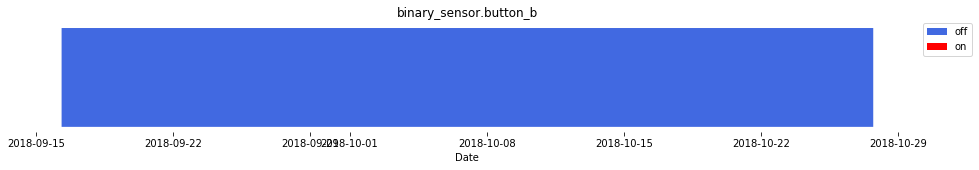

In [16]:
binary_sensors.plot(random.choice(binary_sensors.entities))

That concludes our introduction to getting started with Home Assistant data.